In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import lstsq
from numpy import log,exp


## Step 1: Load the data to collect Pose Estimation Data

In [109]:
# Replace "ground_truth.csv" with your file name and the column name accordingly.
data_pose = pd.read_csv("ground_truth.csv")
y = data_pose['field.pose.pose.position.z'].to_numpy()  # Use to_numpy() instead of .numpy()
N = len(y)

# Total simulation time is 73.343 seconds.
total_time = 73.343  
# Generate time vector using linspace (uniformly spaced)
t = np.linspace(0, total_time, N)

print(f"Loaded {N} samples with a total simulation time of {total_time} s.")

data_pose

Loaded 7332 samples with a total simulation time of 73.343 s.


,%time,field.header.seq,field.header.stamp,field.header.frame_id,field.child_frame_id,field.pose.pose.position.x,field.pose.pose.position.y,field.pose.pose.position.z,field.pose.pose.orientation.x,field.pose.pose.orientation.y,...,field.twist.covariance26,field.twist.covariance27,field.twist.covariance28,field.twist.covariance29,field.twist.covariance30,field.twist.covariance31,field.twist.covariance32,field.twist.covariance33,field.twist.covariance34,field.twist.covariance35
0,14012000000,1400,14011000000,world,base_link,-2.652655,-4.780032,11.874030,0.093371,-0.004297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14022000000,1401,14021000000,world,base_link,-2.649544,-4.783467,11.874463,0.091112,-0.004513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14031000000,1402,14031000000,world,base_link,-2.646444,-4.787083,11.874909,0.088849,-0.004749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14041000000,1403,14041000000,world,base_link,-2.643355,-4.790877,11.875366,0.086569,-0.004963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14051000000,1404,14051000000,world,base_link,-2.640278,-4.794842,11.875836,0.084286,-0.005194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7327,87290000000,8727,87281000000,world,base_link,-0.130365,-22.176993,12.000504,-0.004775,-0.002347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7328,87328000000,8728,87291000000,world,base_link,-0.123218,-22.171268,12.000511,-0.004678,-0.002531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7329,87328000000,8729,87301000000,world,base_link,-0.116081,-22.165538,12.000518,-0.004521,-0.002779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7330,87328000000,8730,87311000000,world,base_link,-0.108954,-22.159803,12.000524,-0.004441,-0.002945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 2: Form the Linear Prediction Model (LPM)

In [110]:
# Choose the model order n (experiment with n; typical choices might be 4-6)
n = 4  # Adjust as needed

Q = []
D = []
for k in range(n, N):
    # Use the previous n measurements to predict y(k)
    Q.append(y[k-n:k][::-1])  # Each row: y(k-1), y(k-2), ..., y(k-n)
    D.append(y[k])
Q = np.array(Q)
D = np.array(D)

## Step 3: Solve for the LPM Coefficients

In [111]:
# Solve Q * A = D using least squares to get coefficients A = [a1, a2, ..., an]
A, residuals, rank, s = lstsq(Q, D, rcond=None)
print("Estimated LPM coefficients:", A)

Estimated LPM coefficients: [ 3.52672251 -4.58974715  2.59914094 -0.53611629]


## Step 4: Construct and Solve the Characteristic Polynomial

In [112]:
# The polynomial is: z^n - a1*z^(n-1) - a2*z^(n-2) - ... - an = 0
poly_coeffs = np.concatenate(([1], -A))
z_roots = np.roots(poly_coeffs)
print("Discrete-time poles (z-roots):", z_roots)

Discrete-time poles (z-roots): [1.00000083+0.j         0.98987965+0.01754411j 0.98987965-0.01754411j
 0.54696237+0.j        ]


## Step 5: Convert to Continuous-Time Poles

In [113]:
# The sampling period T can be calculated as total_time / (N-1)
T = total_time / (N - 1)
lambda_vals = log(z_roots) / T  # Continuous-time poles
print("Continuous-time poles (lambda):", lambda_vals)

Continuous-time poles (lambda): [ 8.33408380e-05+0.j         -1.00103640e+00+1.77136522j
 -1.00103640e+00-1.77136522j -6.03103784e+01+0.j        ]


## Step 6: Build Vandermonde Matrix and Solve for Residues

In [114]:
# Build the Vandermonde matrix Ψ: each row for k = 0 to N-1 is [z1^k, z2^k, ..., zn^k]
Psi = np.vander(z_roots, N, increasing=True).T  # Shape: (N, n)
# Solve for residues B such that Ψ * B ≈ y using least squares
B, residuals_B, rank_B, s_B = lstsq(Psi, y, rcond=None)
print("Estimated residues:", B)

Estimated residues: [11.95793445+1.01386216e-18j -0.02086613+4.53538664e-02j
 -0.02086613-4.53538664e-02j -0.06232877+5.06051364e-17j]


## Step 7: Reconstruct the Signal Using the Prony Model

In [115]:
y_hat = np.zeros(N, dtype=complex)
for i in range(n):
    y_hat += B[i] * exp(lambda_vals[i] * t)
y_hat = y_hat.real  # Only use the real part

## Step 8: Dominant Mode Extraction

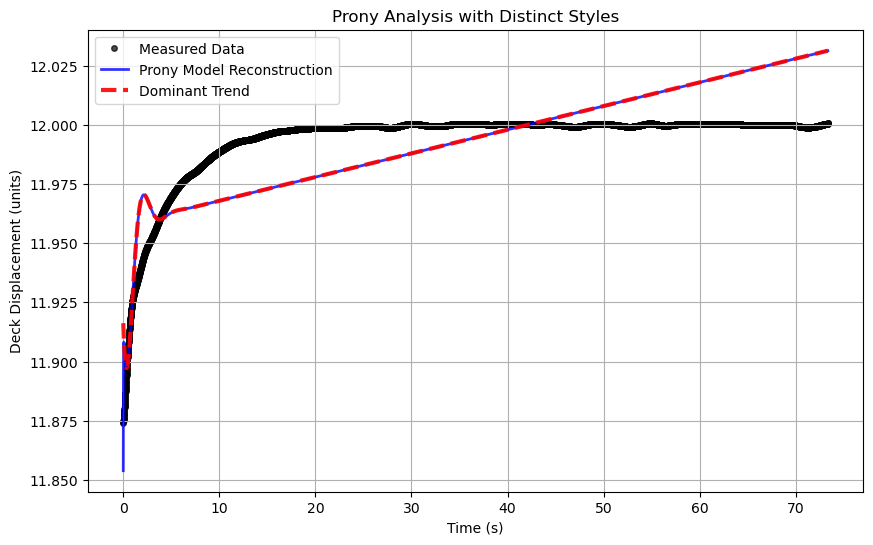

In [116]:
neg_real_parts = np.abs(np.real(lambda_vals[np.real(lambda_vals) < 0]))
if len(neg_real_parts) > 0:
    d = np.min(neg_real_parts)
    Lp = 5 * d
    dominant_indices = [i for i in range(n) if np.abs(np.real(lambda_vals[i])) < Lp]
else:
    dominant_indices = list(range(n))

dominant_trend = np.zeros(N, dtype=complex)
for i in dominant_indices:
    dominant_trend += B[i] * exp(lambda_vals[i] * t)
dominant_trend = dominant_trend.real

plt.figure(figsize=(10, 6))

# Plot measured data (black dots, partially transparent)
plt.plot(t, y, 'ko', markersize=4, alpha=0.7, label='Measured Data', zorder=1)

# Plot full Prony model (blue solid line, thicker width, partially transparent)
plt.plot(t, y_hat, color='blue', linewidth=2, alpha=0.8,
         label='Prony Model Reconstruction', zorder=2)

# Plot dominant trend (red dashed line, thick, on top)
plt.plot(t, dominant_trend, color='red', linestyle='--', linewidth=3, alpha=0.9,
         label='Dominant Trend', zorder=3)

plt.xlabel('Time (s)')
plt.ylabel('Deck Displacement (units)')
plt.title('Prony Analysis with Distinct Styles')
plt.legend()
plt.grid(True)
plt.show()
